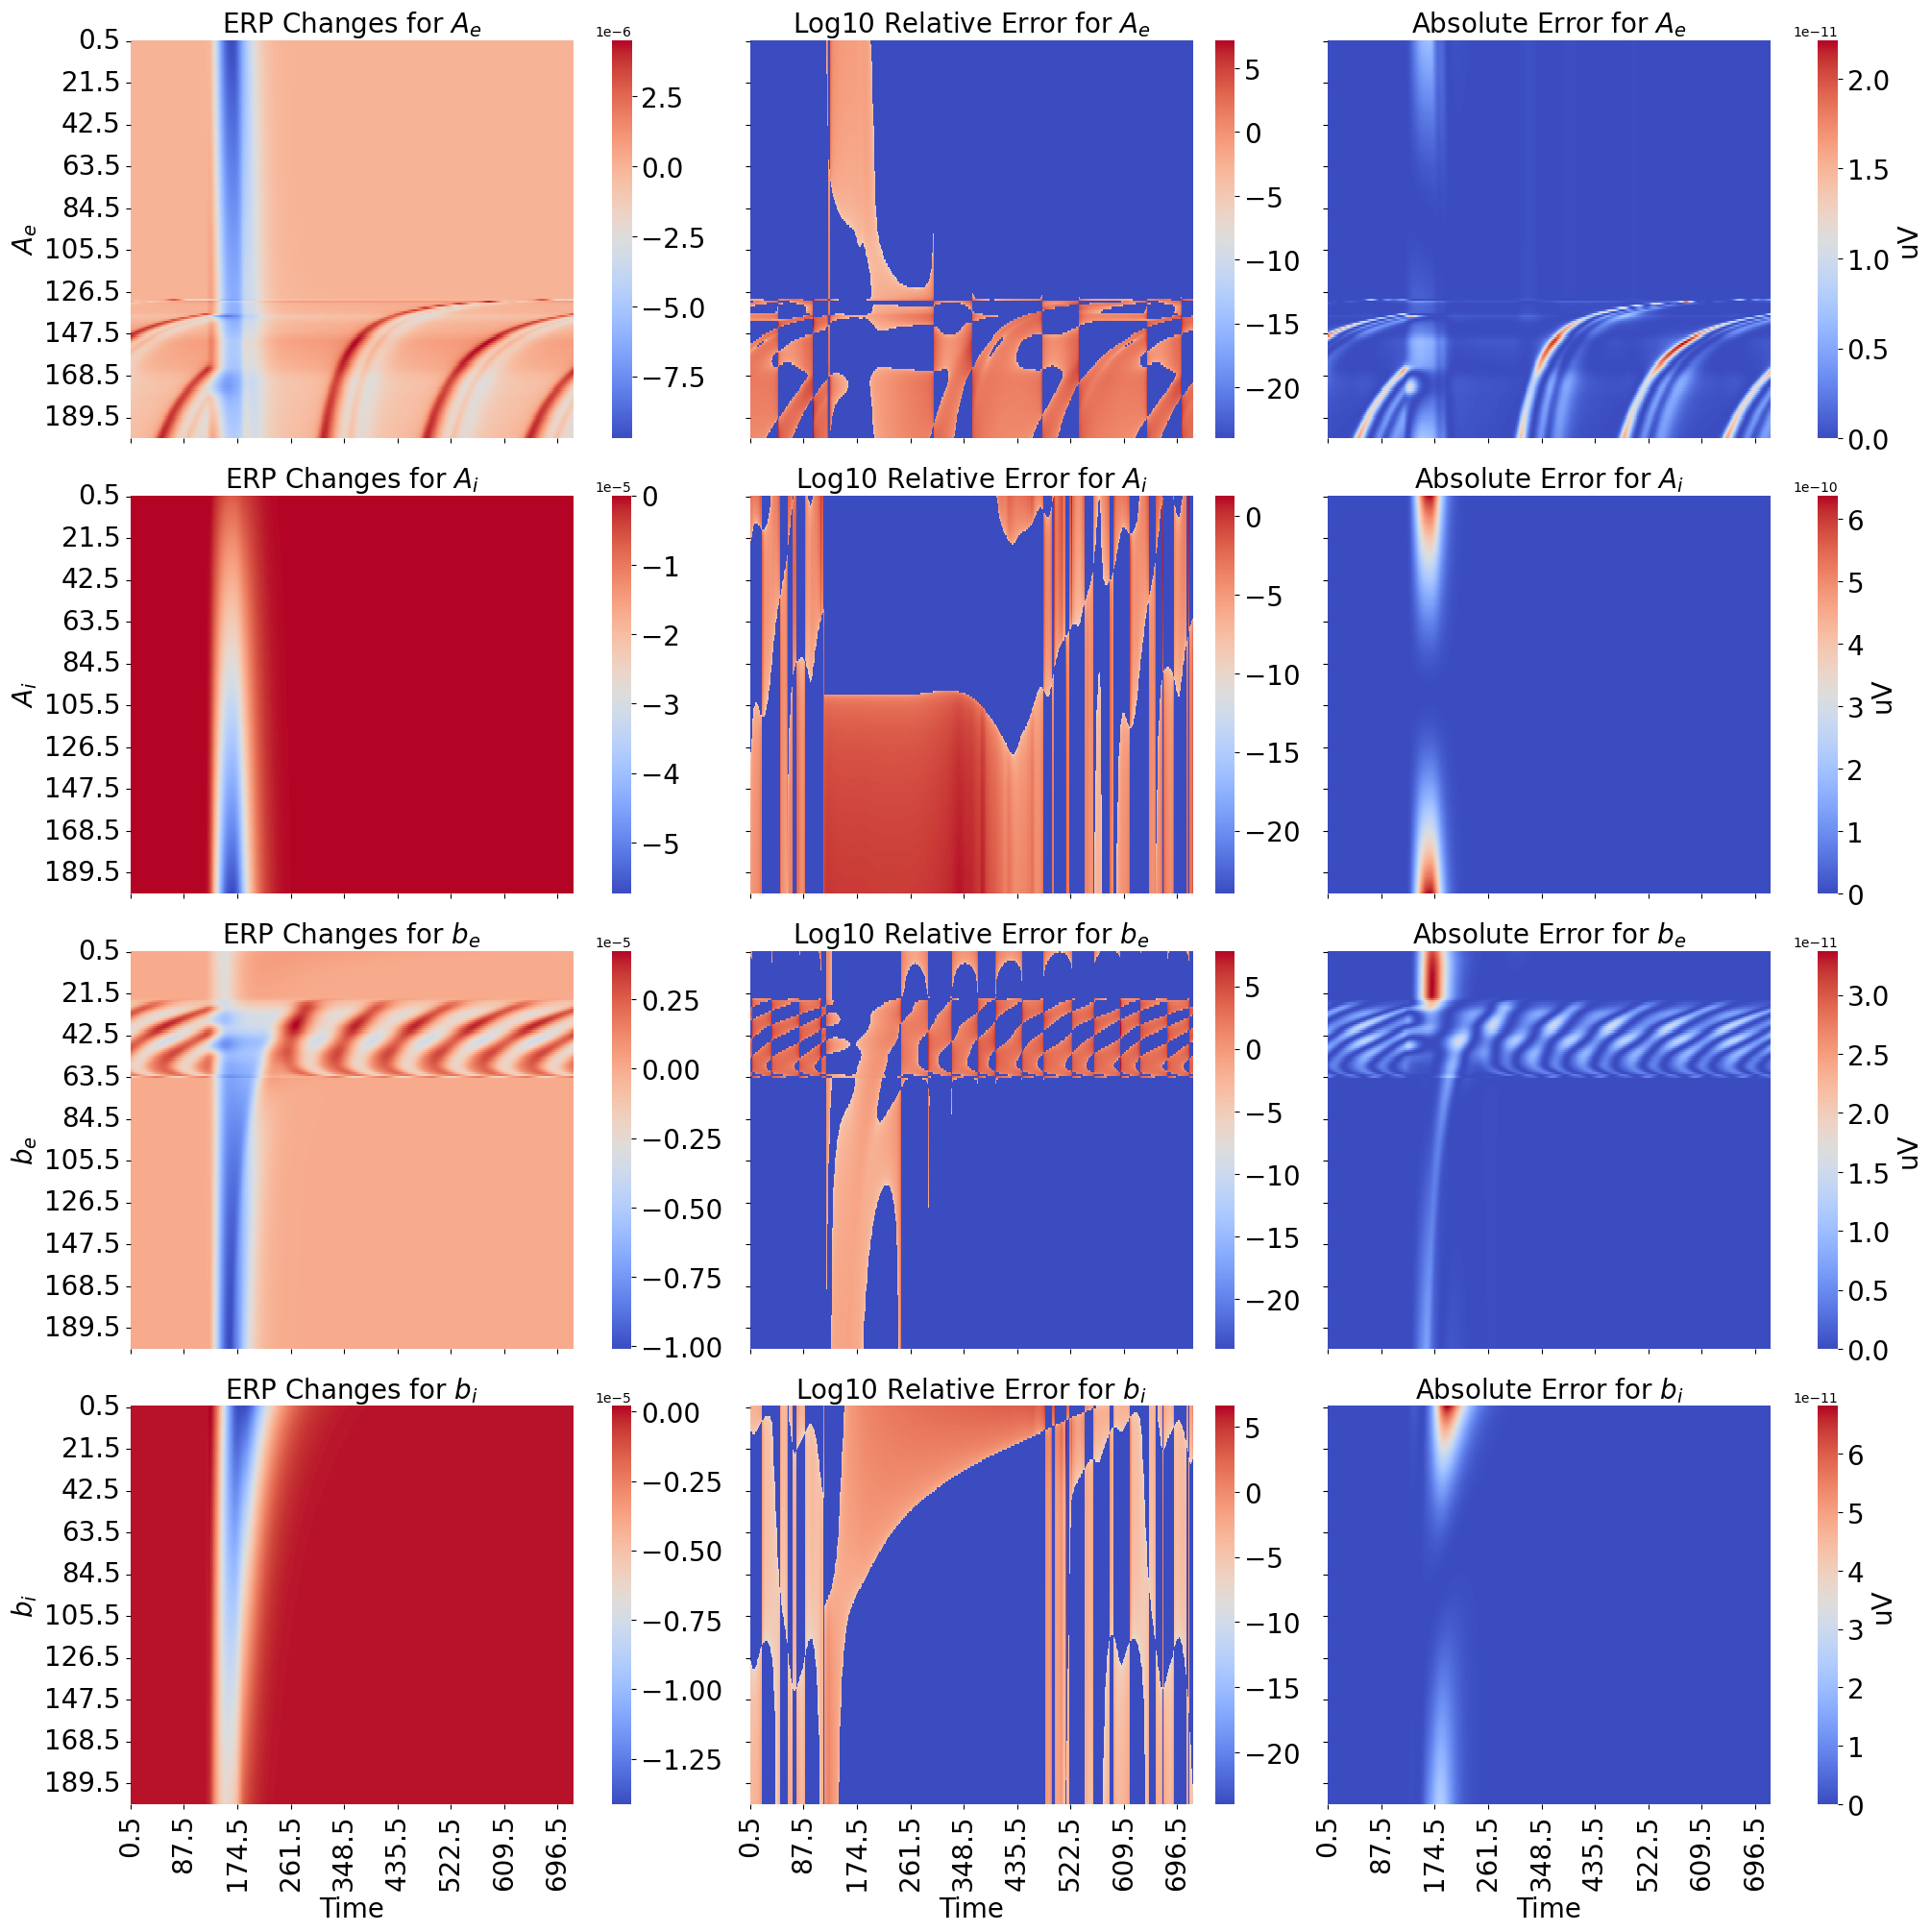

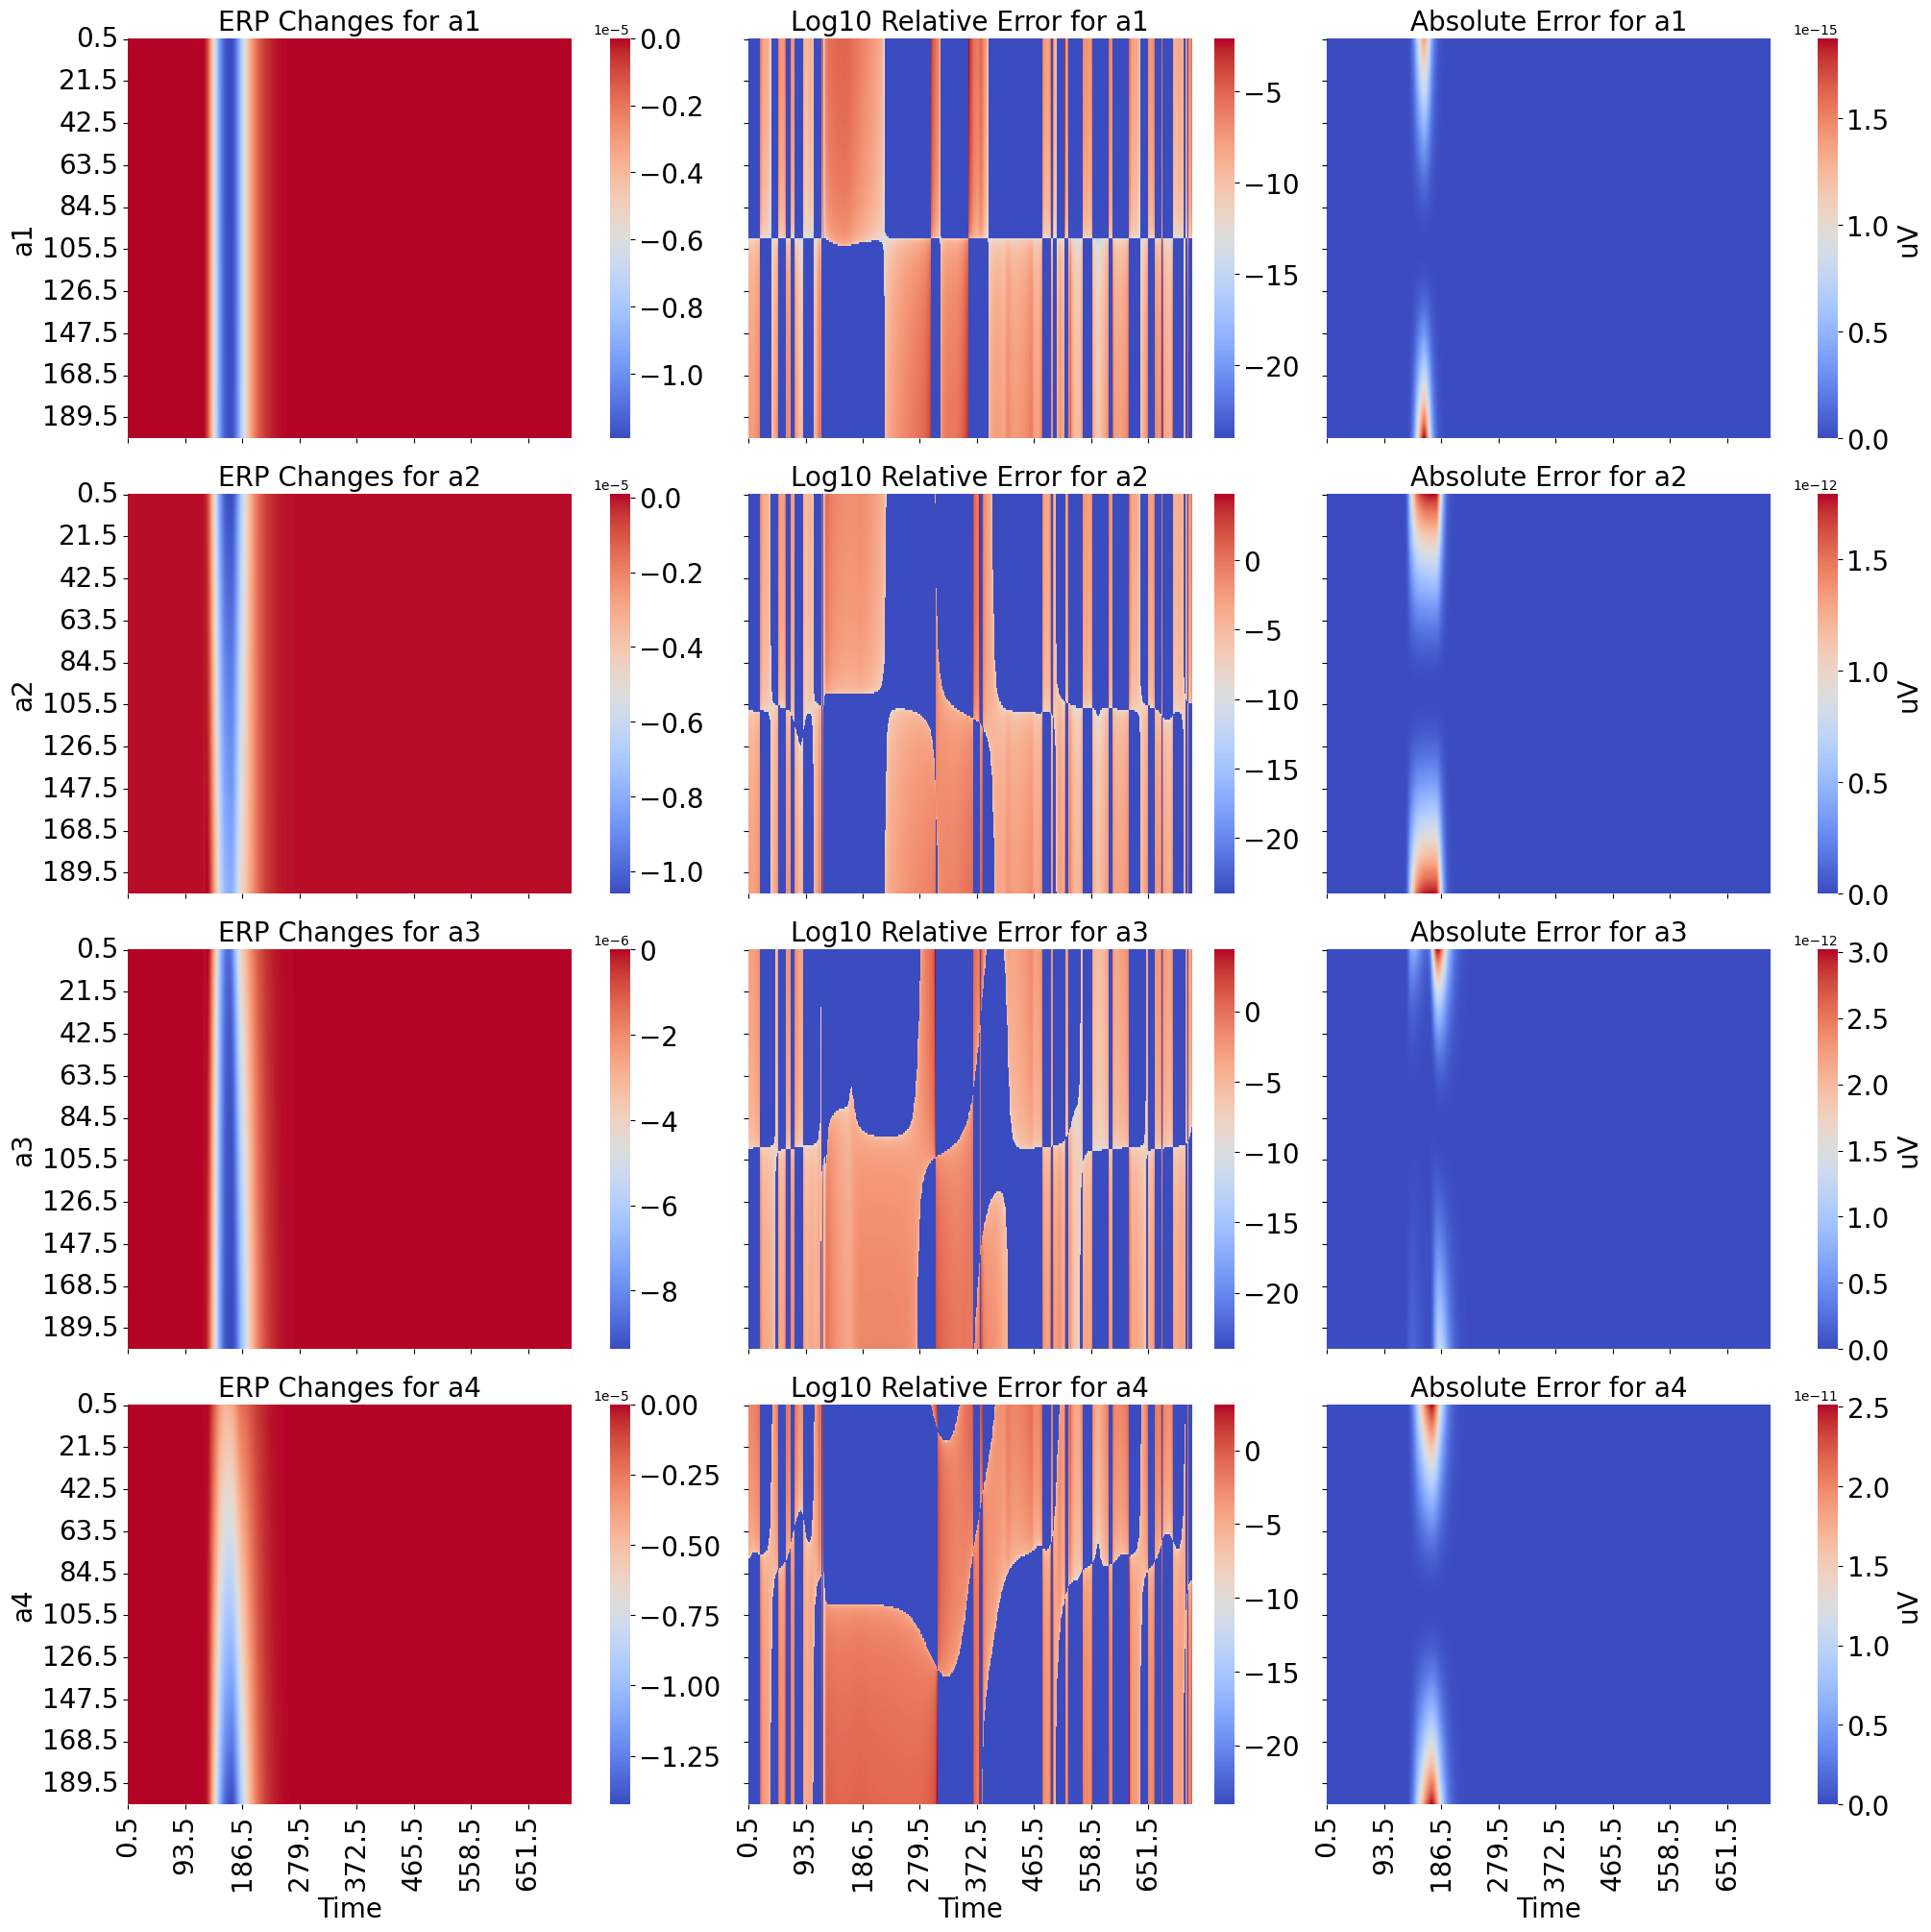

In [31]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter  # Import this

def plot_heatmap(data, ax, title, param_key, fontsize, show_xlabel, show_ylabel, z_label=None):
    df = data.to_dataframe().reset_index()
    df.rename(columns={'__xarray_dataarray_variable__': 'value'}, inplace=True)
    df['time'] = df['time'].round(4)
    df[param_key] = df[param_key].round(3)
    heatmap_data = df.pivot(index=param_key, columns='time', values='value')
    sns.heatmap(heatmap_data, ax=ax, cbar=True, cmap='coolwarm')
    ax.set_title(title, fontsize=fontsize)
    
    if show_xlabel:
        ax.set_xlabel('Time', fontsize=fontsize)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        ax.set_ylabel(param_key, fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Formatter to show ticks with one decimal
    one_decimal_formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")
    ax.xaxis.set_major_formatter(one_decimal_formatter)
    ax.yaxis.set_major_formatter(one_decimal_formatter)

    # Reduce the number of y ticks and set their font size
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::3])  # Keep every third tick
    ax.tick_params(axis='y', labelsize=fontsize)
    
    # Reduce the number of x ticks and set their font size
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::3])  # Keep every third tick
    ax.tick_params(axis='x', labelsize=fontsize)

    # Set the font size for the colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    if z_label:
        cbar.set_label(z_label, fontsize=fontsize)

# Configuration
N = 200
fontsize = 20

# Original column names and corresponding new names
columns_to_call = ['A1', 'B1', 'a', 'b', 'a_1', 'a2', 'a3', 'a4']
new_column_names = [r'$A_{e}$', r'$A_{i}$', r'$b_{e}$', r'$b_{i}$', 'a1', 'a2', 'a3', 'a4']

ch = 'EEG 005'

# Create first figure and axes
fig1, axes1 = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey='row', constrained_layout=True)
# Create second figure and axes
fig2, axes2 = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey='row', constrained_layout=True)

for idx, (param_key, new_param_key) in enumerate(zip(columns_to_call, new_column_names)):
    # Determine which figure and axes to use
    if (idx < 4):
        axes = axes1
        fig = fig1
        idx_in_fig = idx
    else:
        axes = axes2
        fig = fig2
        idx_in_fig = idx - 4

    # File paths
    params_file_path = f'/Users/deepatilwani/Documents/Projects/DCM_withMNE/Apri13_2024/Sensitivity_Analysis/y_{param_key}_{N}.pickle'
    evoked_file_path = f'/Users/deepatilwani/Documents/Projects/DCM_withMNE/Apri13_2024/Sensitivity_Analysis/evoked_xarr_{param_key}_{N}.nc'

    # Load data
    with open(params_file_path, 'rb') as handle:
        params_data = pickle.load(handle)
    p_values = [d[param_key] for d in params_data if param_key in d]
    y_df = pd.DataFrame({new_param_key: p_values})
    evoked_xarray = xr.open_dataset(evoked_file_path)

    # Data manipulation
    y_xr = y_df.set_index(evoked_xarray.sim_no.values).to_xarray().rename({'index': 'sim_no'})
    overall_mean = evoked_xarray.mean(dim='sim_no')
    mean_ke = evoked_xarray.groupby(y_xr[new_param_key]).mean()
    diff_from_mean = mean_ke - overall_mean
    relative_error = np.log10(((diff_from_mean / overall_mean).clip(min=1e-12))**2)
    absolute_error = (diff_from_mean) ** 2

    # Determine whether to show x-axis label
    show_xlabel = idx_in_fig // 3 == 3
    

    # Plotting
    plot_heatmap(mean_ke.sel(ch_names=ch), axes[idx_in_fig, 0], f'ERP Changes for {new_param_key}', 
                 new_param_key, fontsize,
                  show_xlabel=show_xlabel, show_ylabel=True)
    plot_heatmap(relative_error.sel(ch_names=ch), axes[idx_in_fig, 1],
                  f'Log10 Relative Error for {new_param_key}', new_param_key,
                    fontsize, show_xlabel=show_xlabel, show_ylabel=False)
    plot_heatmap(absolute_error.sel(ch_names=ch), axes[idx_in_fig, 2],
                  f'Absolute Error for {new_param_key}', new_param_key,
                    fontsize, show_xlabel=show_xlabel, show_ylabel=False, z_label='uV')

# Set shared y-axis label and x-axis label for the last row
for ax in axes1[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
for ax in axes1[-1, :]:
    ax.set_xlabel('Time', fontsize=fontsize)

for ax in axes2[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
for ax in axes2[-1, :]:
    ax.set_xlabel('Time', fontsize=fontsize)

# Save and show the figures
fig1.savefig('all_sensitivity_plot_1.png', dpi=300)
fig2.savefig('all_sensitivity_plot_2.png', dpi=300)

plt.show()


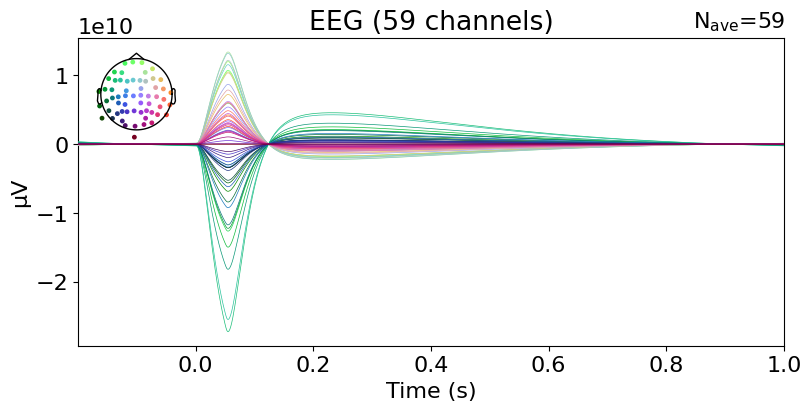

In [61]:
import matplotlib
from mne.viz import set_browser_backend


# Assuming 'evoked' is a list of Evoked objects
fig = evoked[0].plot(show=False)  # Do not show the plot immediately
fig.set_size_inches(8, 4, forward=True)  # Set the figure size

# Now display the figure
plt.show()



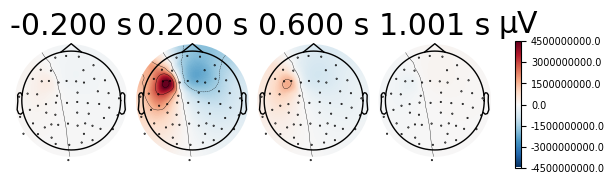

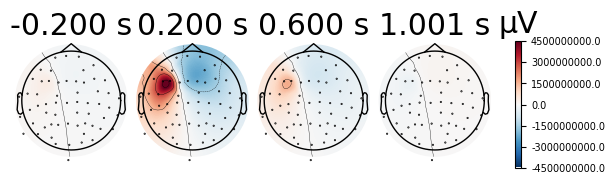

In [48]:
# Assuming 'evoked' is a list of Evoked objects
evoked[0].plot_topomap()